# 6-8. 프로젝트: 자율주행 보조 시스템 만들기

목표 : 조건을 만족하는 자율 주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
- 사람이 한 명 이상 있는 경우
- 차량의 크기(width or height)가 300px이상인 경우  

### 1-1. 훈련된 모델을 로드하기 

In [2]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
#from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

### 1-2. Go-Stop을 판별하는 함수 

In [9]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300, visualize=False):
    # 이미지 읽어오기 
    image = read_image_bgr(img_path)
    
    # copy image to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }
    
    # Tpreprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale

    
    # inference 
    action = "Go"
    if  visualize:    

        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < 0.5:
                break

            b = box.astype(int)        
            width = b[2]-b[0]
            height = b[3]-b[1]

            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            
             # 라벨이 사람인 경우이거나 차량의 크기(width or height)가 300px이상인 경우    
            if label == 1 or width >= size_limit or height >= size_limit:
                action = "Stop"
                break


        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()    

    return action

print(self_drive_assist(img_path))   

Go


## 2. 자율주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.


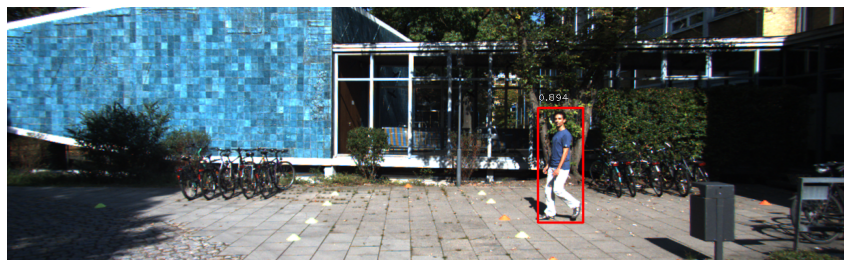

Stop


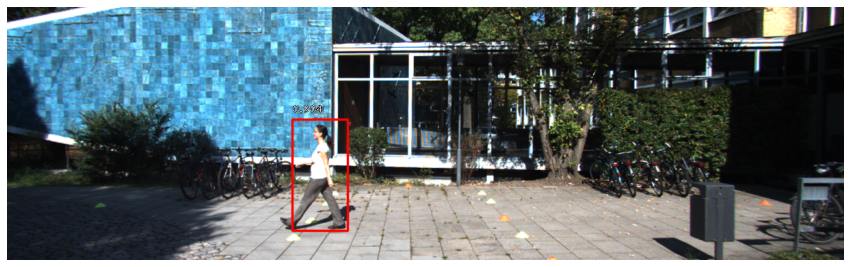

Stop


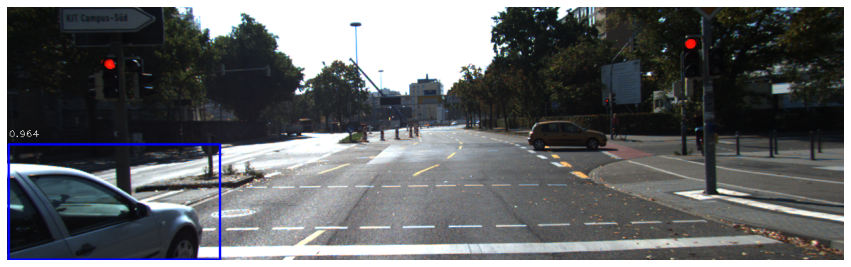

Stop


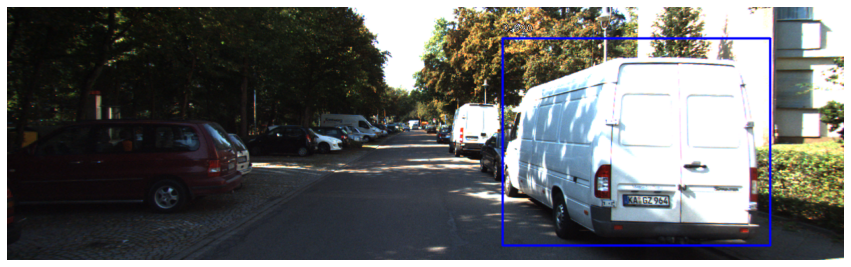

Stop


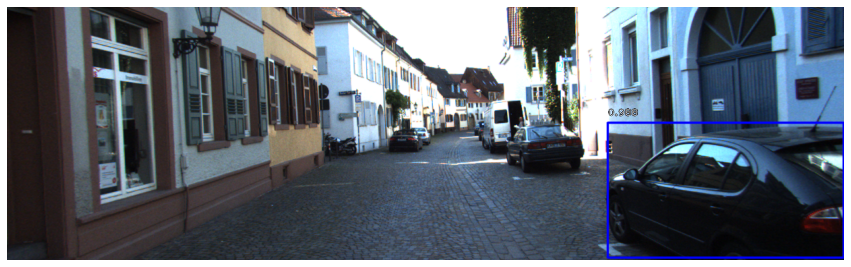

Stop


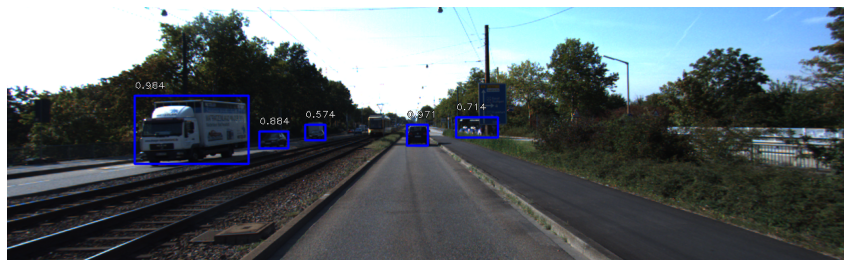

Go


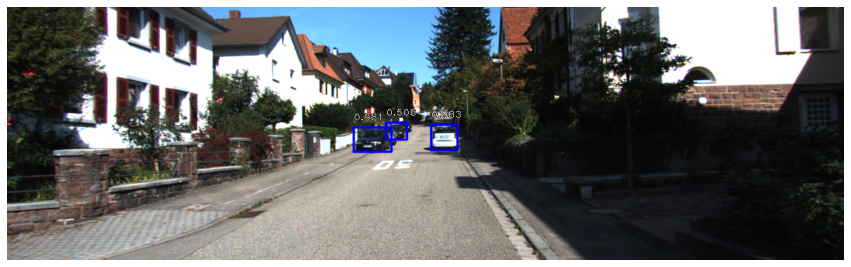

Go


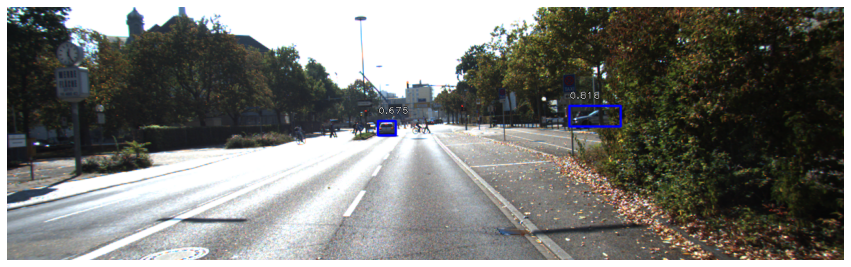

Go


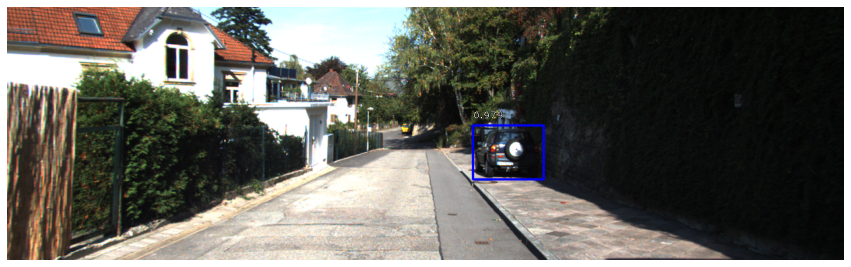

Go


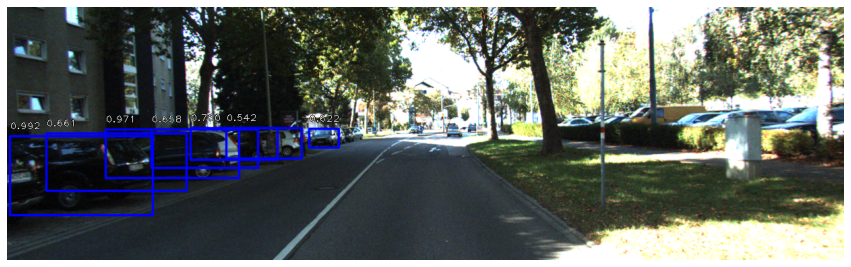

Go
100점입니다.


In [8]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(image_path, visualize=True)
        print(pred)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

## 느낀점

RetinaNet이라는 1-stage detector를 미리 학습시킨 라이브러리를 활용하여 자율 주행 보조 시스템을 만들었다.  
물론 완벽히 안전하다고는 할 수 없지만, object를 차와 사람으로 꽤 잘 구분하였다.   
이전 시간 노드에서 모델 학습시 한 이미지에 객체를 하나만 학습하는 오류로 훈련을 다시 하기도 했으나 재미있는 작업이었다.   